In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from sklearn.covariance import GraphicalLassoCV
import numpy.linalg as la
from sklearn.ensemble import RandomForestClassifier
from keras import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import GRU
from keras.layers import SimpleRNN
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from keras.utils.vis_utils import plot_model
import xgboost as xgb

In [2]:
df_ind = pd.read_csv('All_indicator_1d.csv')

(868, 270)

In [3]:
df_ori = pd.read_csv('BTC_data_1d_2019-01-01.csv')

In [4]:
nrow = df_ind.shape[0]
ncol = df_ind.shape[1]

In [5]:
na_res = np.zeros(ncol)
for i in range(ncol):
    na_res[i] = np.sum(df_ind.iloc[:,i].isna().sum())

In [6]:
ind_na = np.arange(ncol)[na_res != nrow]

In [7]:
ind_row = np.max(na_res[na_res != nrow]).astype(int)

In [8]:
ori_ind = np.concatenate((np.arange(2,7), np.arange(8,12)),axis=0)

In [9]:
indi_ind = np.arange(1,171)

In [10]:
df_ori_cl = df_ori.iloc[ind_row:nrow,ori_ind]


In [11]:
df_ind_cl = df_ind.iloc[ind_row:nrow, ind_na]
df_ind_cl = df_ind_cl.iloc[:,indi_ind]

In [12]:
df_ind_cl.shape

(899, 170)

In [13]:
df_ind_cl_con = df_ind_cl

In [14]:
def chatterjee(x,y):
    n=len(x)
    df=pd.DataFrame({'X':x,'Y':y})
    df['rank_x']=df['X'].rank()
    df['rank_y']=df['Y'].rank()
    df=df.sort_values(by='rank_x')
    sum_term1=df['rank_y'].diff().abs().sum()
    sum_term2=((df['rank_y']-1)*(n+1-df['rank_y'])).sum()
    #return 1-(n*sum_term1)/(2*sum_term2)
    return (1-3*sum_term1/(pow(n,2)-1))

### Original Feature

#### Log Diff

In [87]:
for i in range(df_ori_cl.shape[1]):
    temp_log = np.diff(np.log(df_ori_cl.iloc[:,i])).reshape((df_ori_cl.shape[0]-1,1))
    if i == 0:
        ori_diff = np.array(temp_log)
    else:
        ori_diff = np.concatenate((ori_diff, temp_log), axis=1)

In [88]:
n_ori_diff_row = ori_diff.shape[0]

In [89]:
ndays = 30
for i in range(1,(ndays+1)):
    if(i == 1):
        ori_matrix = np.array(ori_diff[(i-1):(i-1 + n_ori_diff_row-ndays),:])
    else:
        ori_matrix = np.concatenate((ori_matrix, np.array(ori_diff[(i-1):(i-1 + n_ori_diff_row-ndays),:])), axis=1)
ori_res_con = ori_diff[ndays:n_ori_diff_row,3]
ori_res_sign = np.array((ori_res_con > 0).astype(int))

In [90]:
matrix = ori_matrix
full_matrix = matrix

#### Without Log

In [1029]:
ndays = 30
ori_cl_copy = np.array(df_ori_cl)
n_ori_cl_copy_row = ori_cl_copy.shape[0]
for i in range(1,(ndays+1)):
    if(i == 1):
        ori_matrix = np.array(ori_cl_copy[(i-1):(i-1 + n_ori_cl_copy_row-ndays),:])
    else:
        ori_matrix = np.concatenate((ori_matrix, np.array(ori_cl_copy[(i-1):(i-1 + n_ori_cl_copy_row-ndays),:])), axis=1)
ori_res_con = ori_diff[ndays:n_ori_diff_row,3]
ori_res_sign = np.array((ori_res_con > 0).astype(int))

In [1027]:
matrix = ori_matrix

### Indicator Feature

In [15]:
indi_cat = np.arange(76,138)
indi_con = np.setdiff1d(np.arange(df_ind_cl.shape[1]),indi_cat)

In [16]:
indi_cl_con = np.array(df_ind_cl.iloc[:,indi_con])
indi_cl_cat = np.array(df_ind_cl.iloc[:,indi_cat])

In [17]:
indi_cl_con_nonpos_ind = np.unique(np.argwhere(indi_cl_con<=0)[:,1])
indi_cl_con_pos_ind = np.setdiff1d(np.arange(indi_cl_con.shape[1]),indi_cl_con_nonpos_ind)

In [18]:
indi_cl_con_nonpos = indi_cl_con[:,indi_cl_con_nonpos_ind]
indi_cl_con_pos = indi_cl_con[:,indi_cl_con_pos_ind]

In [ ]:
for i in range(indi_cl_con.shape[1]):
    temp_log = np.diff(np.log(indi_cl_con[:,i])).reshape((indi_cl_con.shape[0]-1,1))
    if i == 0:
        ind_diff = np.array(temp_log)
    else:
        ind_diff = np.concatenate((ind_diff, temp_log), axis=1)

#### Direct Diff

In [1172]:
for i in range(indi_cl_con_pos.shape[1]):
    temp_log = np.diff(indi_cl_con_pos[:,i]).reshape((indi_cl_con_pos.shape[0]-1,1))
    if i == 0:
        indi_diff = np.array(temp_log)
    else:
        indi_diff = np.concatenate((indi_diff, temp_log), axis=1)

In [1278]:
ndays = 30
for i in range(ndays):
    if(i == 0):
        matrix = np.array(indi_diff[0:indi_diff.shape[0]-ndays,:])
    else:
        matrix = np.concatenate((matrix,np.array(indi_diff[i:(i+indi_diff.shape[0]-ndays),:])),axis=1)
    matrix = np.concatenate((matrix, indi_cl_con_nonpos[(i+1):(i+indi_cl_con_nonpos.shape[0]-ndays),:]),axis = 1)
    matrix = np.concatenate((matrix, indi_cl_cat[(i+1):(i+indi_cl_cat.shape[0]-ndays),:]),axis = 1)

In [783]:
for i in range(ndays):
    if(i == 0):
        matrix = np.array(df_ind_cl.iloc[1:df_ind_cl.shape[0]-ndays,:])
    else:
        matrix = np.concatenate((matrix,np.array(df_ind_cl.iloc[(i+1):(i+df_ind_cl.shape[0]-ndays),:])),axis=1)

In [1279]:
response = np.array((np.diff(df_ori_cl.iloc[:,3])>0).astype(int))
response = response[ndays:response.shape[0]]

In [1174]:
response = np.diff(df_ori_cl.iloc[:,3])

In [1286]:
shuf_ind = np.arange(matrix.shape[0])
np.random.shuffle(shuf_ind)
train_length = int(0.8 * matrix.shape[0])
test_length = matrix.shape[0] - train_length
train_ind = shuf_ind[0:train_length]
test_ind = shuf_ind[train_length:ori_matrix.shape[0]]
train_X = matrix[train_ind,:]
train_Y = response[train_ind]
test_X = matrix[test_ind,:]
test_Y = response[test_ind]

#### Log Diff

In [46]:
for i in range(indi_cl_con_pos.shape[1]):
    temp_log = np.diff(np.log(indi_cl_con_pos[:,i])).reshape((indi_cl_con_pos.shape[0]-1,1))
    if i == 0:
        indi_diff = np.array(temp_log)
    else:
        indi_diff = np.concatenate((indi_diff, temp_log), axis=1)

In [47]:
ndays = 30
for i in range(ndays):
    if(i == 0):
        matrix = np.array(indi_diff[0:indi_diff.shape[0]-ndays,:])
    else:
        matrix = np.concatenate((matrix,np.array(indi_diff[i:(i+indi_diff.shape[0]-ndays),:])),axis=1)
    matrix = np.concatenate((matrix, indi_cl_con_nonpos[(i+1):(i+indi_cl_con_nonpos.shape[0]-ndays),:]),axis = 1)
    matrix = np.concatenate((matrix, indi_cl_cat[(i+1):(i+indi_cl_cat.shape[0]-ndays),:]),axis = 1)

In [48]:
full_matrix = matrix

#### Without Log

In [1128]:
for i in range(ndays):
    if(i == 0):
        matrix = np.array(df_ind_cl.iloc[1:df_ind_cl.shape[0]-ndays,:])
    else:
        matrix = np.concatenate((matrix,np.array(df_ind_cl.iloc[(i+1):(i+df_ind_cl.shape[0]-ndays),:])),axis=1)

In [1129]:
matrix.shape

(868, 5100)

### Response

In [49]:
response = np.array((np.diff(df_ori_cl.iloc[:,3])>0).astype(int))
response = response[ndays:response.shape[0]]

### Chatterjee

In [50]:
cor_res = np.zeros(matrix.shape[1])
#temp_y = df_ori_cl.iloc[1:df_ori_cl.shape[0],3]
temp_y = response
for i in range(matrix.shape[1]):
    temp_x = matrix[:,i]
    cor_res[i] = chatterjee(temp_x, temp_y)

In [51]:
ind = np.argsort(-cor_res)
matrix = matrix[:,ind[0:300]]

#### Training&Testing Split

In [91]:
shuf_ind = np.arange(matrix.shape[0])
np.random.shuffle(shuf_ind)
train_length = int(0.8 * matrix.shape[0])
test_length = matrix.shape[0] - train_length
train_ind = shuf_ind[0:train_length]
test_ind = shuf_ind[train_length:matrix.shape[0]]
train_X = matrix[train_ind,:]
train_Y = response[train_ind]
test_X = matrix[test_ind,:]
test_Y = response[test_ind]

### Logistic

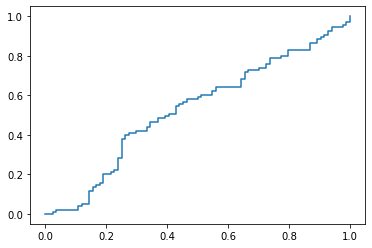

In [1354]:
model_logistic = LogisticRegression(solver='liblinear')
model_logistic.fit(train_X,train_Y)
prob = np.zeros(test_X.shape[0])
proba_res = model_logistic.predict_proba(test_X)
prob = proba_res[:,1] - proba_res[:,0]
fpr1, tpr1, thresholds = roc_curve(test_Y, prob, pos_label = 1)
plt.plot(fpr1, tpr1)

In [1355]:
acc1 = model_logistic.score(test_X, test_Y)
acc1

0.5195530726256983

In [1356]:
acc_mat[0,turn] = acc1

### Logistic-l1

C:\Users\cml\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


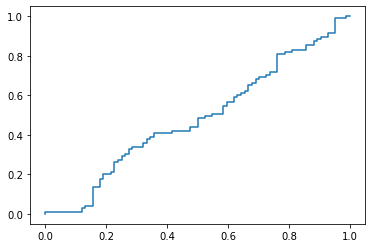

In [1357]:
model_logistic_l1 = LogisticRegression(solver='liblinear', penalty='l1')
model_logistic_l1.fit(train_X,train_Y)
prob = np.zeros(test_X.shape[0])
proba_res = model_logistic_l1.predict_proba(test_X)
prob = proba_res[:,1] - proba_res[:,0]
fpr2, tpr2, thresholds = roc_curve(test_Y, prob, pos_label = 1)
plt.plot(fpr2, tpr2)

In [1358]:
acc2 = model_logistic_l1.score(test_X, test_Y)
acc2

0.48044692737430167

In [1359]:
acc_mat[1,turn] = acc2

### Logistic-l2

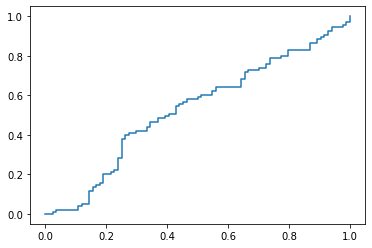

In [1360]:
model_logistic_l2 = LogisticRegression(solver='liblinear', penalty='l2')
model_logistic_l2.fit(train_X,train_Y)
prob = np.zeros(test_X.shape[0])
proba_res = model_logistic_l2.predict_proba(test_X)
prob = proba_res[:,1] - proba_res[:,0]
fpr3, tpr3, thresholds = roc_curve(test_Y, prob, pos_label = 1)
plt.plot(fpr3, tpr3)

In [1361]:
acc3 = model_logistic_l2.score(test_X, test_Y)
acc3

0.5195530726256983

In [1362]:
acc_mat[2,turn] = acc3

### Random Forest

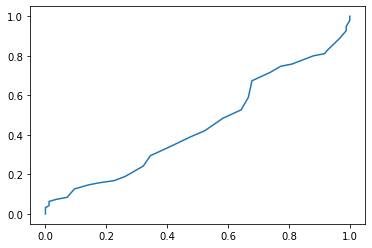

In [1363]:
clf_entro = RandomForestClassifier(max_depth=1000, criterion='entropy',random_state=1)
clf_entro.fit(train_X,train_Y)
proba_res = clf_entro.predict_proba(test_X)
prob = proba_res[:,1] - proba_res[:,0]
fpr4, tpr4, thresholds = roc_curve(test_Y, prob, pos_label = 1)
plt.plot(fpr4, tpr4)

In [1364]:
acc4 = clf_entro.score(test_X,test_Y)
acc4

0.44692737430167595

In [1365]:
acc_mat[3,turn] = acc4

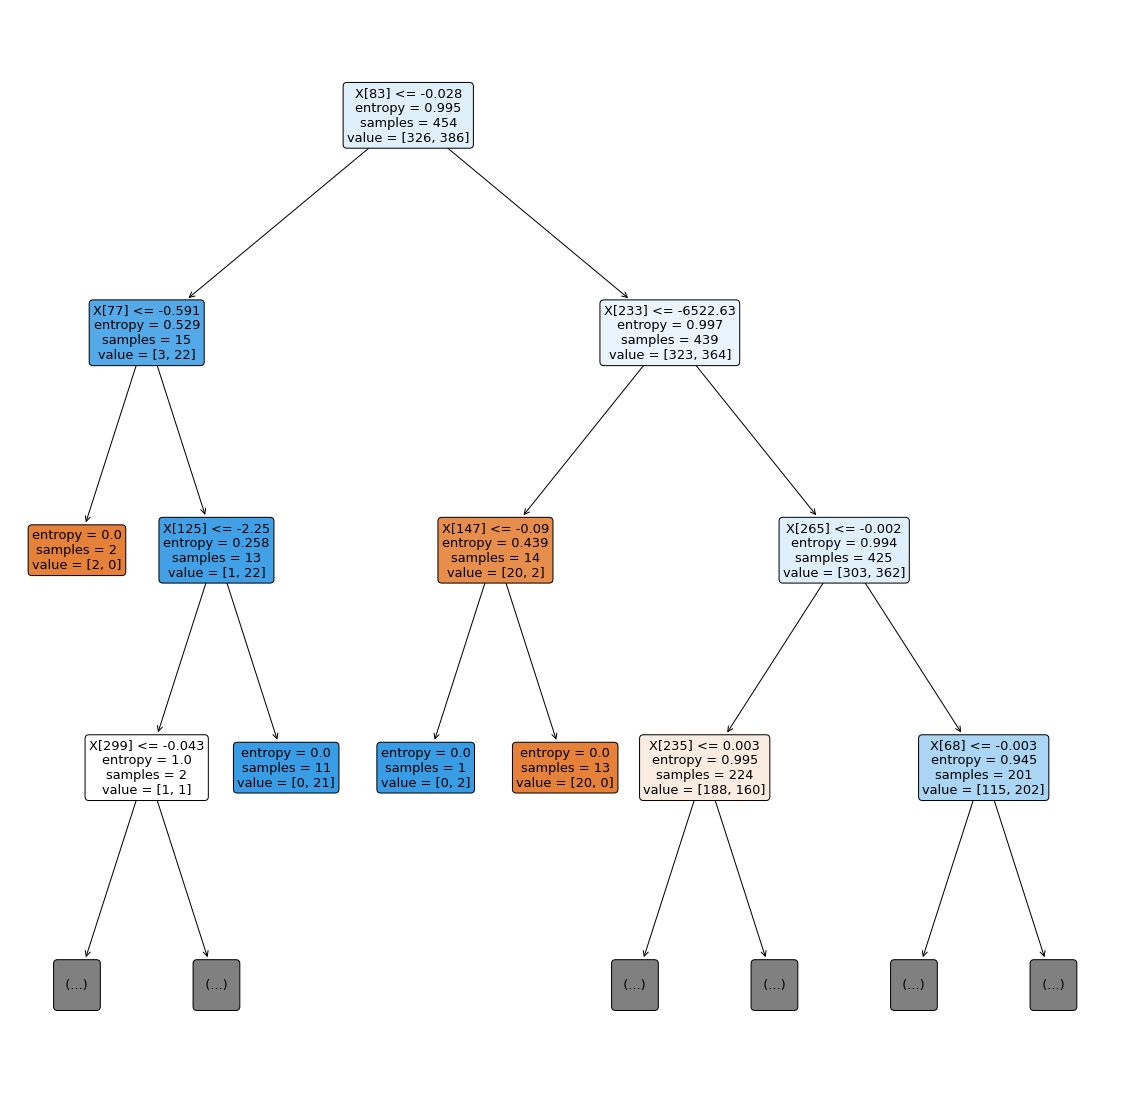

In [1366]:
plt.figure(figsize=(20,20))
plot_tree(clf_entro.estimators_[0], 
          filled=True, impurity=True, 
          rounded=True, max_depth= 3)
plt.savefig('tree_entro.png',format='png',bbox_inches = "tight")

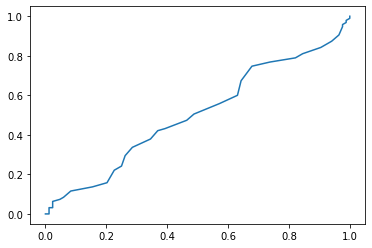

In [1367]:
clf_gini = RandomForestClassifier(max_depth=1000, criterion='gini',random_state=1)
clf_gini.fit(train_X,train_Y)
proba_res = clf_gini.predict_proba(test_X)
prob = proba_res[:,1] - proba_res[:,0]
fpr5, tpr5, thresholds = roc_curve(test_Y, prob, pos_label = 1)
plt.plot(fpr5, tpr5)

In [1368]:
acc5 = clf_gini.score(test_X,test_Y)
acc5

0.5083798882681564

In [1369]:
acc_mat[4,turn] = acc5

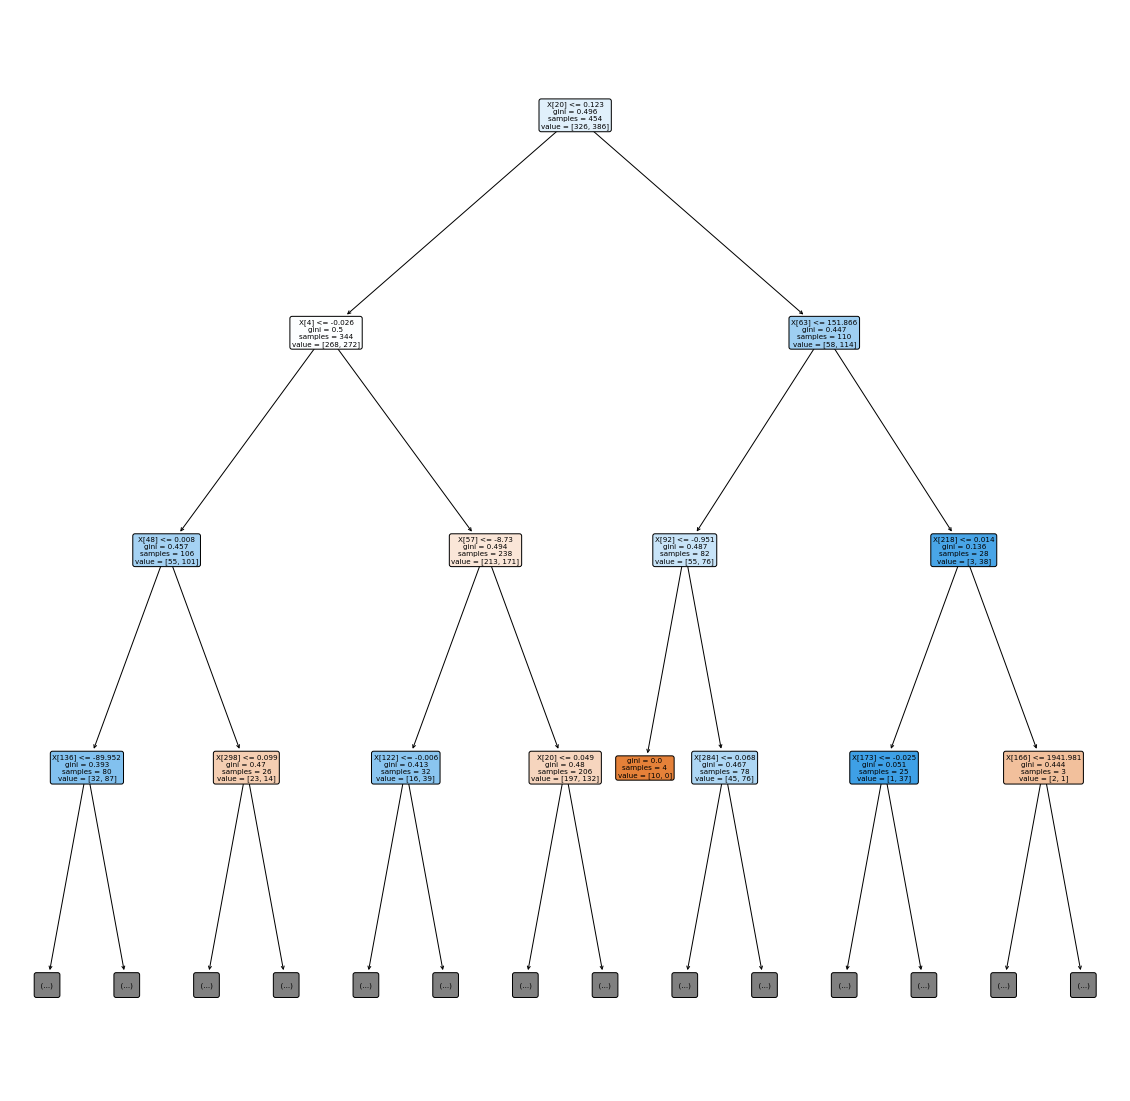

In [1370]:
plt.figure(figsize=(20,20))
plot_tree(clf_gini.estimators_[0], 
          filled=True, impurity=True, 
          rounded=True, max_depth= 3)
plt.savefig('tree_gini.png',format='png',bbox_inches = "tight")

### Sequential Neural Network

Epoch 1/3
23/23 [==============================] - 0s 589us/step - loss: 0.7175
Epoch 2/3
23/23 [==============================] - 0s 589us/step - loss: 0.7053
Epoch 3/3
23/23 [==============================] - 0s 635us/step - loss: 0.7028


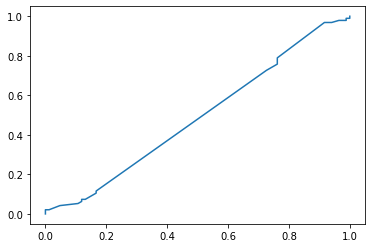

In [1371]:
act_2 = 'tanh'
model_nn = Sequential()
model_nn.add(Dense(units=20, activation=act_2))
#model_nn.add(Dropout(0.2))
model_nn.add(Dense(units=20, activation=act_2))
#model_nn.add(Dense(units=4, activation=act_2))
model_nn.add(Dense(units=1, activation="sigmoid"))
model_nn.compile(optimizer="adamax", loss="binary_crossentropy")
model_nn.fit(train_X, train_Y, epochs=3)
prob = model_nn.predict(test_X).flatten()
fpr6, tpr6, thresholds = roc_curve(test_Y, prob, pos_label = 1)
plt.plot(fpr6,tpr6)

In [1372]:
pred = np.where(model_nn.predict(test_X) > 0.5, 1, 0)

In [1373]:
acc6 = accuracy_score(test_Y, pred)
acc6

0.5307262569832403

In [1374]:
acc_mat[5,turn] = acc6

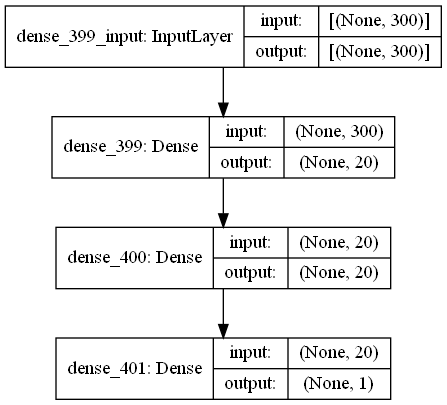

In [1341]:
plot_model(model_nn, to_file='model_nn.png', show_shapes=True, show_layer_names=True)

### LSTM

In [1479]:
train_X.shape

(694, 270)

In [1480]:
x_train=train_X.reshape(train_X.shape[0],ndays,int(train_X.shape[1]/ndays))
x_test = test_X.reshape(test_X.shape[0],ndays,int(train_X.shape[1]/ndays))

In [1481]:
x_train.shape

(694, 30, 9)

Epoch 1/4
22/22 [==============================] - 1s 5ms/step - loss: 0.6936
Epoch 2/4
22/22 [==============================] - 0s 4ms/step - loss: 0.6929
Epoch 3/4
22/22 [==============================] - 0s 5ms/step - loss: 0.6925
Epoch 4/4
22/22 [==============================] - 0s 5ms/step - loss: 0.6921


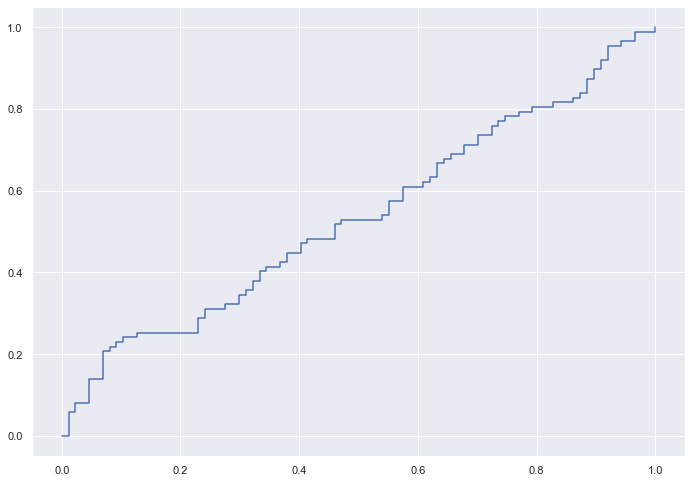

In [1482]:
regressor_LSTM = Sequential()

regressor_LSTM.add(LSTM(units = int(train_X.shape[1]/ndays), input_shape = (ndays,int(train_X.shape[1]/ndays)) , activation='tanh',recurrent_activation='tanh'))
regressor_LSTM.add(Dense(units=1, activation='sigmoid'))

regressor_LSTM.compile(optimizer = 'adam', loss = 'binary_crossentropy')

regressor_LSTM.fit(x_train, train_Y, epochs = 4)#, batch_size = 4096)

prob = regressor_LSTM.predict(x_test).flatten()
fpr7, tpr7, thresholds = roc_curve(test_Y, prob, pos_label = 1)
plt.plot(fpr7,tpr7)

In [ ]:
pred = np.where(regressor_LSTM.predict(x_test).flatten()>0.5, 1, 0)

In [ ]:
acc7 = accuracy_score(test_Y, pred)
acc7

In [ ]:
acc_mat[6,turn] = acc7

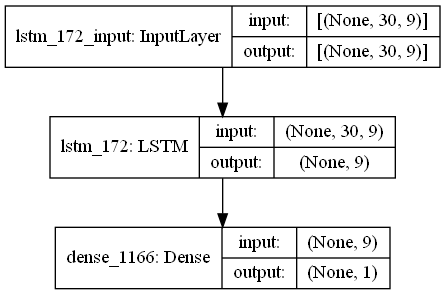

In [1483]:
plot_model(regressor_LSTM, to_file='LSTM.png', show_shapes=True, show_layer_names=True)

### SimpleRNN

Epoch 1/4
22/22 [==============================] - 1s 3ms/step - loss: 0.7444
Epoch 2/4
22/22 [==============================] - 0s 3ms/step - loss: 0.7150
Epoch 3/4
22/22 [==============================] - 0s 3ms/step - loss: 0.7007
Epoch 4/4
22/22 [==============================] - 0s 3ms/step - loss: 0.6946


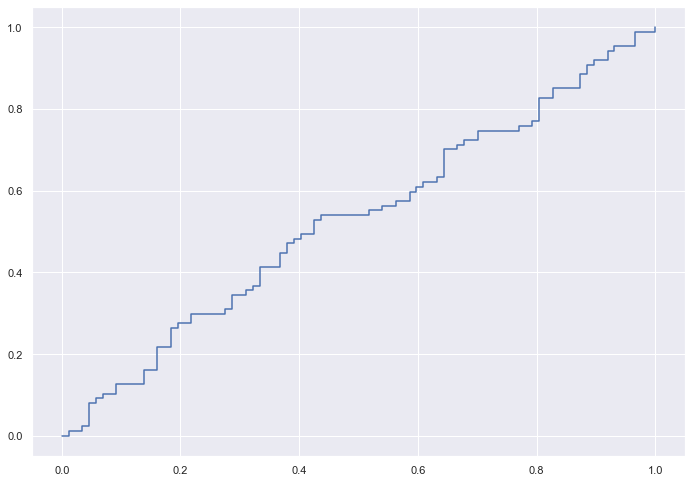

In [1484]:
regressor_RNN = Sequential()

regressor_RNN.add(SimpleRNN(units = int(train_X.shape[1]/ndays), input_shape = (ndays,int(train_X.shape[1]/ndays)) , activation='tanh'))
regressor_RNN.add(Dense(units=1, activation='sigmoid'))

regressor_RNN.compile(optimizer = 'adam', loss = 'binary_crossentropy')

regressor_RNN.fit(x_train, train_Y, epochs = 4)#, batch_size = 4096)

prob = regressor_RNN.predict(x_test).flatten()
fpr8, tpr8, thresholds = roc_curve(test_Y, prob, pos_label = 1)
plt.plot(fpr8,tpr8)

In [ ]:
pred = np.where(regressor_RNN.predict(x_test).flatten()>0.5, 1, 0)

In [ ]:
acc8 = accuracy_score(test_Y, pred)
acc8

In [ ]:
acc_mat[7,turn] = acc8

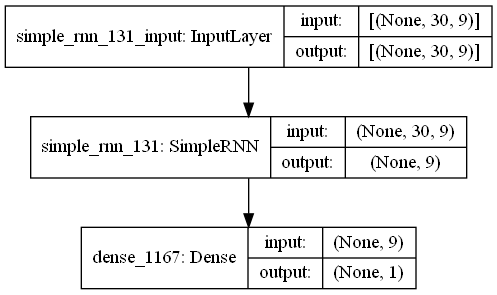

In [1485]:
plot_model(regressor_RNN, to_file='RNN.png', show_shapes=True, show_layer_names=True)

### GRU

Epoch 1/4
22/22 [==============================] - 1s 6ms/step - loss: 0.6942 - binary_accuracy: 0.5000
Epoch 2/4
22/22 [==============================] - 0s 5ms/step - loss: 0.6898 - binary_accuracy: 0.5159
Epoch 3/4
22/22 [==============================] - 0s 5ms/step - loss: 0.6881 - binary_accuracy: 0.5360
Epoch 4/4
22/22 [==============================] - 0s 6ms/step - loss: 0.6874 - binary_accuracy: 0.5490


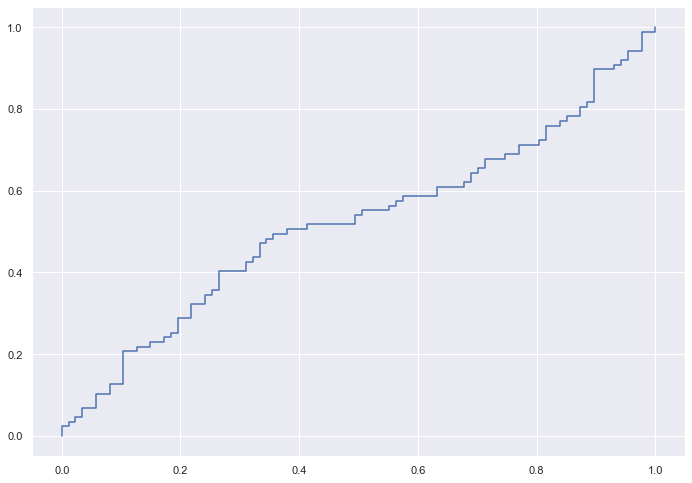

In [1486]:
regressor_GRU = Sequential()

regressor_GRU.add(GRU(units = int(train_X.shape[1]/ndays), input_shape = (ndays,int(train_X.shape[1]/ndays)) , activation='tanh',recurrent_activation='tanh'))
regressor_GRU.add(Dense(units=1, activation='sigmoid'))

regressor_GRU.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=tf.keras.metrics.BinaryAccuracy())

regressor_GRU.fit(x_train, train_Y, epochs = 4)#, batch_size = 4096)

prob = regressor_GRU.predict(x_test).flatten()
fpr9, tpr9, thresholds = roc_curve(test_Y, prob, pos_label = 1)
plt.plot(fpr9,tpr9)

In [ ]:
pred = np.where(regressor_GRU.predict(x_test).flatten()>0.5, 1, 0)

In [ ]:
acc9 = accuracy_score(test_Y, pred)
acc9

In [ ]:
acc_mat[8,turn] = acc9

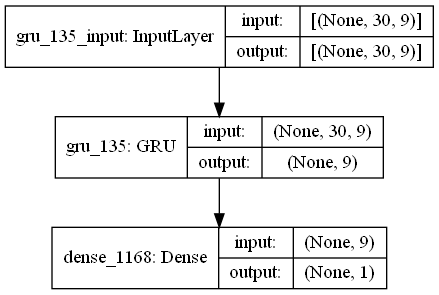

In [1487]:
plot_model(regressor_GRU, to_file='GRU.png', show_shapes=True, show_layer_names=True)

### XGboost

In [1375]:
shuf_ind_xgb = np.arange(train_X.shape[0])
np.random.shuffle(shuf_ind_xgb)
train_length_xgb = int(0.8 * train_X.shape[0])
val_length_xgb = train_X.shape[0] - train_length_xgb
train_ind_xgb = shuf_ind_xgb[0:train_length_xgb]
val_ind_xgb = shuf_ind_xgb[train_length_xgb:train_X.shape[0]]
train_X_xgb = train_X[train_ind_xgb,:]
train_Y_xgb = train_Y[train_ind_xgb]
val_X_xgb = train_X[val_ind_xgb,:]
val_Y_xgb = train_Y[val_ind_xgb]

In [1376]:
dtrain = xgb.DMatrix(train_X, label=train_Y)
dtest = xgb.DMatrix(test_X, label=test_Y)

In [1377]:
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [1378]:
num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-auc:0.596241	train-auc:0.62679
[1]	eval-auc:0.605388	train-auc:0.680506
[2]	eval-auc:0.573058	train-auc:0.720737
[3]	eval-auc:0.550877	train-auc:0.750818
[4]	eval-auc:0.571992	train-auc:0.776234
[5]	eval-auc:0.557331	train-auc:0.794141
[6]	eval-auc:0.554261	train-auc:0.810103
[7]	eval-auc:0.526128	train-auc:0.828283
[8]	eval-auc:0.510777	train-auc:0.843137
[9]	eval-auc:0.52688	train-auc:0.856685


In [1346]:
dtest = xgb.DMatrix(test_X)
prob = bst.predict(dtest)

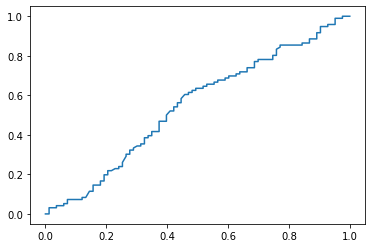

In [1347]:
fpr10, tpr10, thresholds = roc_curve(test_Y, prob, pos_label = 1)
plt.plot(fpr10,tpr10)

In [1348]:
pred = np.where(prob>0.5, 1, 0)
acc10 = accuracy_score(test_Y, pred)
acc10

0.553072625698324

In [1349]:
acc_mat[9,turn] = acc10

<Figure size 1440x1440 with 0 Axes>

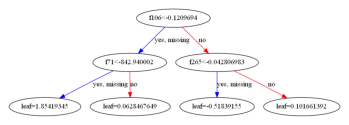

In [1350]:
plt.figure(figsize=(20,20))
xgb.plot_tree(bst, num_trees=2)
plt.savefig('xgboost.png',format='png',bbox_inches = "tight")

### Accuracy matrix

In [99]:
acc_mat = np.zeros((10,25))
for i in range(25):
    print('step'+str(i+1))
    
    shuf_ind = np.arange(matrix.shape[0])
    np.random.shuffle(shuf_ind)
    train_length = int(0.8 * matrix.shape[0])
    test_length = matrix.shape[0] - train_length
    train_ind = shuf_ind[0:train_length]
    test_ind = shuf_ind[train_length:matrix.shape[0]]
    #Partial Variables
    train_X = matrix[train_ind,:]
    train_Y = response[train_ind]
    test_X = matrix[test_ind,:]
    test_Y = response[test_ind]
    #Reserve Validation
    val_X = matrix[test_ind,:]
    val_Y = response[test_ind]
    #Down Accuracy
    #test_X = test_X[test_Y==0,:]
    #test_Y = test_Y[test_Y==0]
    #Logistic
    model_logistic = LogisticRegression(solver='liblinear')
    model_logistic.fit(train_X,train_Y)
    acc_mat[0, i] = model_logistic.score(test_X, test_Y)
    
    #Logistic-l1
    model_logistic_l1 = LogisticRegression(solver='liblinear', penalty='l1')
    model_logistic_l1.fit(train_X,train_Y)
    acc_mat[1, i] = model_logistic_l1.score(test_X, test_Y)
    
    #Logistic-l2
    model_logistic_l2 = LogisticRegression(solver='liblinear', penalty='l2')
    model_logistic_l2.fit(train_X,train_Y)
    acc_mat[2, i] = model_logistic_l2.score(test_X, test_Y)
    
    #Entropy Random Forest
    clf_entro = RandomForestClassifier(max_depth=1000, criterion='entropy',random_state=1)
    clf_entro.fit(train_X,train_Y)
    acc_mat[3, i] = clf_entro.score(test_X, test_Y)
    
    #Gini Random Forest
    clf_gini = RandomForestClassifier(max_depth=1000, criterion='gini',random_state=1)
    clf_gini.fit(train_X,train_Y)
    acc_mat[4, i] = clf_gini.score(test_X, test_Y)
    
    #Sequential Neural Network
    act_2 = 'tanh'
    model_nn = Sequential()
    model_nn.add(Dense(units=20, activation=act_2))
    #model_nn.add(Dropout(0.2))
    model_nn.add(Dense(units=20, activation=act_2))
    #model_nn.add(Dense(units=4, activation=act_2))
    model_nn.add(Dense(units=1, activation="sigmoid"))
    model_nn.compile(optimizer="adamax", loss="binary_crossentropy")
    model_nn.fit(train_X, train_Y, epochs=3)
    pred = np.where(model_nn.predict(test_X) > 0.5, 1, 0)
    acc_mat[5, i] = accuracy_score(test_Y, pred)
    
    #XGBoost
    dtrain = xgb.DMatrix(train_X, label=train_Y)
    dtest = xgb.DMatrix(val_X, label=val_Y)
    param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
    param['nthread'] = 4
    param['eval_metric'] = 'auc'
    evallist = [(dtest, 'eval'), (dtrain, 'train')]
    num_round = 10
    bst = xgb.train(param, dtrain, num_round, evallist)
    dtest = xgb.DMatrix(test_X)
    prob = bst.predict(dtest)
    pred = np.where(prob>0.5, 1, 0)
    acc_mat[9, i] = accuracy_score(test_Y, pred)
    
    #FULL Variable
    train_X = full_matrix[train_ind,:]
    train_Y = response[train_ind]
    test_X = full_matrix[test_ind,:]
    test_Y = response[test_ind]
    
    #LSTM
    x_train=train_X.reshape(train_X.shape[0],ndays,int(train_X.shape[1]/ndays))
    x_test = test_X.reshape(test_X.shape[0],ndays,int(train_X.shape[1]/ndays))
    regressor_LSTM = Sequential()
    regressor_LSTM.add(LSTM(units = int(train_X.shape[1]/ndays), input_shape = (ndays,int(train_X.shape[1]/ndays)) , activation='tanh',recurrent_activation='tanh'))
    regressor_LSTM.add(Dense(units=1, activation='sigmoid'))
    regressor_LSTM.compile(optimizer = 'adam', loss = 'binary_crossentropy')
    regressor_LSTM.fit(x_train, train_Y, epochs = 4)#, batch_size = 4096)
    prob = regressor_LSTM.predict(x_test).flatten()
    pred = np.where(prob>0.5, 1, 0)
    acc_mat[6, i] = accuracy_score(test_Y, pred)
    
    #SimpleRNN
    regressor_RNN = Sequential()
    regressor_RNN.add(SimpleRNN(units = int(train_X.shape[1]/ndays), input_shape = (ndays,int(train_X.shape[1]/ndays)) , activation='tanh'))
    regressor_RNN.add(Dense(units=1, activation='sigmoid'))
    regressor_RNN.compile(optimizer = 'adam', loss = 'binary_crossentropy')
    regressor_RNN.fit(x_train, train_Y, epochs = 4)#, batch_size = 4096)
    prob = regressor_RNN.predict(x_test).flatten()
    pred = np.where(prob>0.5, 1, 0)
    acc_mat[7, i] = accuracy_score(test_Y, pred)
    
    #GRU
    regressor_GRU = Sequential()
    regressor_GRU.add(GRU(units = int(train_X.shape[1]/ndays), input_shape = (ndays,int(train_X.shape[1]/ndays)) , activation='tanh',recurrent_activation='tanh'))
    regressor_GRU.add(Dense(units=1, activation='sigmoid'))
    regressor_GRU.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=tf.keras.metrics.BinaryAccuracy())
    regressor_GRU.fit(x_train, train_Y, epochs = 4)#, batch_size = 4096)
    prob = regressor_GRU.predict(x_test).flatten()
    pred = np.where(prob>0.5, 1, 0)
    acc_mat[8, i] = accuracy_score(test_Y, pred)

step1
Epoch 1/3
22/22 [==============================] - 0s 712us/step - loss: 0.7070
Epoch 2/3
22/22 [==============================] - 0s 617us/step - loss: 0.6886
Epoch 3/3
22/22 [==============================] - 0s 617us/step - loss: 0.6823
[0]	eval-auc:0.451878	train-auc:0.634904
[1]	eval-auc:0.464755	train-auc:0.695497
[2]	eval-auc:0.453073	train-auc:0.731923
[3]	eval-auc:0.477366	train-auc:0.762916
[4]	eval-auc:0.467344	train-auc:0.786482
[5]	eval-auc:0.484535	train-auc:0.809418
[6]	eval-auc:0.489712	train-auc:0.831336
[7]	eval-auc:0.492168	train-auc:0.844534
[8]	eval-auc:0.503186	train-auc:0.859183
[9]	eval-auc:0.494889	train-auc:0.878339
Epoch 1/4
22/22 [==============================] - 1s 4ms/step - loss: 0.6933
Epoch 2/4
22/22 [==============================] - 0s 5ms/step - loss: 0.6928
Epoch 3/4
22/22 [==============================] - 0s 5ms/step - loss: 0.6925
Epoch 4/4
22/22 [==============================] - 0s 4ms/step - loss: 0.6922
Epoch 1/4
22/22 [===============

22/22 [==============================] - 0s 5ms/step - loss: 0.6911 - binary_accuracy: 0.5346
Epoch 3/4
22/22 [==============================] - 0s 5ms/step - loss: 0.6900 - binary_accuracy: 0.5288
Epoch 4/4
22/22 [==============================] - 0s 4ms/step - loss: 0.6894 - binary_accuracy: 0.5231
step6
Epoch 1/3
22/22 [==============================] - 0s 522us/step - loss: 0.7251
Epoch 2/3
22/22 [==============================] - 0s 522us/step - loss: 0.6901
Epoch 3/3
22/22 [==============================] - 0s 522us/step - loss: 0.6795
[0]	eval-auc:0.463165	train-auc:0.613599
[1]	eval-auc:0.481886	train-auc:0.674601
[2]	eval-auc:0.485791	train-auc:0.723271
[3]	eval-auc:0.500471	train-auc:0.76129
[4]	eval-auc:0.495556	train-auc:0.794562
[5]	eval-auc:0.487407	train-auc:0.814536
[6]	eval-auc:0.476566	train-auc:0.831927
[7]	eval-auc:0.468485	train-auc:0.852584
[8]	eval-auc:0.490236	train-auc:0.87055
[9]	eval-auc:0.476498	train-auc:0.880618
Epoch 1/4
22/22 [===========================

22/22 [==============================] - 0s 2ms/step - loss: 0.6934
Epoch 3/4
22/22 [==============================] - 0s 2ms/step - loss: 0.6895
Epoch 4/4
22/22 [==============================] - 0s 2ms/step - loss: 0.6871
Epoch 1/4
22/22 [==============================] - 1s 5ms/step - loss: 0.6988 - binary_accuracy: 0.4726
Epoch 2/4
22/22 [==============================] - 0s 5ms/step - loss: 0.6956 - binary_accuracy: 0.5072
Epoch 3/4
22/22 [==============================] - 0s 5ms/step - loss: 0.6940 - binary_accuracy: 0.5043
Epoch 4/4
22/22 [==============================] - 0s 5ms/step - loss: 0.6937 - binary_accuracy: 0.5014
step11
Epoch 1/3
22/22 [==============================] - 0s 569us/step - loss: 0.7189
Epoch 2/3
22/22 [==============================] - 0s 522us/step - loss: 0.6901
Epoch 3/3
22/22 [==============================] - 0s 570us/step - loss: 0.6785
[0]	eval-auc:0.523388	train-auc:0.605636
[1]	eval-auc:0.505219	train-auc:0.701184
[2]	eval-auc:0.525106	train-auc

22/22 [==============================] - 0s 4ms/step - loss: 0.6925
Epoch 3/4
22/22 [==============================] - 0s 4ms/step - loss: 0.6924
Epoch 4/4
22/22 [==============================] - 0s 4ms/step - loss: 0.6916
Epoch 1/4
22/22 [==============================] - 1s 3ms/step - loss: 0.7083
Epoch 2/4
22/22 [==============================] - 0s 2ms/step - loss: 0.7017
Epoch 3/4
22/22 [==============================] - 0s 2ms/step - loss: 0.6983
Epoch 4/4
22/22 [==============================] - 0s 2ms/step - loss: 0.6963
Epoch 1/4
22/22 [==============================] - 1s 5ms/step - loss: 0.6978 - binary_accuracy: 0.5086
Epoch 2/4
22/22 [==============================] - 0s 5ms/step - loss: 0.6925 - binary_accuracy: 0.5231
Epoch 3/4
22/22 [==============================] - 0s 5ms/step - loss: 0.6910 - binary_accuracy: 0.5159
Epoch 4/4
22/22 [==============================] - 0s 5ms/step - loss: 0.6896 - binary_accuracy: 0.5288
step16
Epoch 1/3
22/22 [========================

[6]	eval-auc:0.532912	train-auc:0.834976
[7]	eval-auc:0.535705	train-auc:0.847518
[8]	eval-auc:0.536237	train-auc:0.861206
[9]	eval-auc:0.535572	train-auc:0.87752
Epoch 1/4
22/22 [==============================] - 1s 4ms/step - loss: 0.6926
Epoch 2/4
22/22 [==============================] - 0s 4ms/step - loss: 0.6918
Epoch 3/4
22/22 [==============================] - 0s 4ms/step - loss: 0.6912
Epoch 4/4
22/22 [==============================] - 0s 4ms/step - loss: 0.6902
Epoch 1/4
22/22 [==============================] - 1s 2ms/step - loss: 0.7358
Epoch 2/4
22/22 [==============================] - 0s 3ms/step - loss: 0.7105
Epoch 3/4
22/22 [==============================] - 0s 3ms/step - loss: 0.6972
Epoch 4/4
22/22 [==============================] - 0s 3ms/step - loss: 0.6903
Epoch 1/4
22/22 [==============================] - 1s 5ms/step - loss: 0.6920 - binary_accuracy: 0.5173
Epoch 2/4
22/22 [==============================] - 0s 5ms/step - loss: 0.6878 - binary_accuracy: 0.5576
Epoch

22/22 [==============================] - 0s 522us/step - loss: 0.6772
[0]	eval-auc:0.608466	train-auc:0.612884
[1]	eval-auc:0.5625	train-auc:0.686372
[2]	eval-auc:0.546032	train-auc:0.725777
[3]	eval-auc:0.570966	train-auc:0.760315
[4]	eval-auc:0.591534	train-auc:0.786405
[5]	eval-auc:0.57295	train-auc:0.80704
[6]	eval-auc:0.574669	train-auc:0.83219
[7]	eval-auc:0.582606	train-auc:0.855022
[8]	eval-auc:0.573148	train-auc:0.866214
[9]	eval-auc:0.568452	train-auc:0.882086
Epoch 1/4
22/22 [==============================] - 1s 4ms/step - loss: 0.6931
Epoch 2/4
22/22 [==============================] - 0s 4ms/step - loss: 0.6925
Epoch 3/4
22/22 [==============================] - 0s 5ms/step - loss: 0.6921
Epoch 4/4
22/22 [==============================] - 0s 4ms/step - loss: 0.6918
Epoch 1/4
22/22 [==============================] - 1s 2ms/step - loss: 0.7364
Epoch 2/4
22/22 [==============================] - 0s 3ms/step - loss: 0.7197
Epoch 3/4
22/22 [==============================] - 0s 3ms

### Boxplot

In [100]:
boxplot_df = pd.DataFrame({ 'method':['Logistic','L1-Logistic','L2-Logistic','Entropy Random Forest','Gini Random Forest', 'Sequential Neural Network','LSTM','SimpleRNN','GRU','XGboost']*25,
                          'accuracy':acc_mat.T.flatten()})


In [101]:
pred = (ori_matrix[:,264] > 0).astype(int)
acc_drift = accuracy_score(response, pred)
down_acc_drift = accuracy_score(response[response==0],pred[response==0])

In [102]:
acc_line = acc_drift

In [96]:
acc_line = down_acc_drift

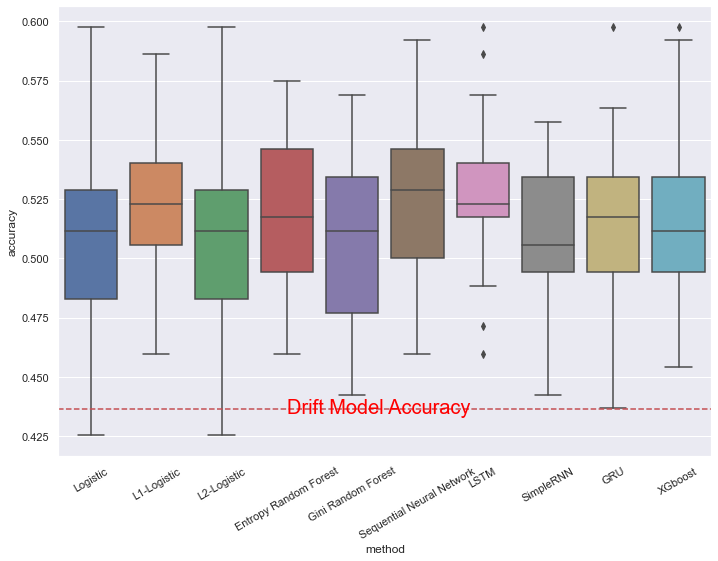

In [103]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
g = sns.boxplot(x='method',y='accuracy',data=boxplot_df)
g.set_xticklabels(g.get_xticklabels(),rotation=30)
g.axhline(acc_line,color='r',linestyle='--')
plt.text(3, acc_line-0.002,'Drift Model Accuracy', fontsize=20, color = 'red')
plt.savefig('accuracy_boxplot.png')

In [104]:
acc_line

0.43663594470046085

### ROC

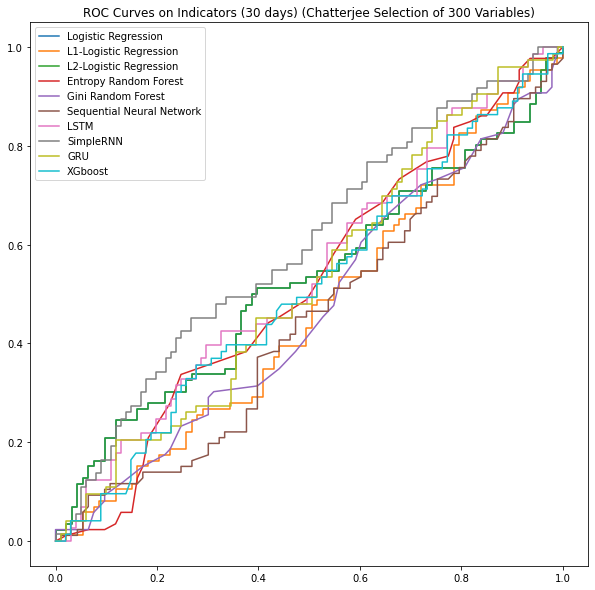

In [1260]:
plt.figure(figsize=(10,10))
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='L1-Logistic Regression')
plt.plot(fpr3, tpr3, label='L2-Logistic Regression')
plt.plot(fpr4, tpr4, label='Entropy Random Forest')
plt.plot(fpr5, tpr5, label='Gini Random Forest')
plt.plot(fpr6, tpr6, label='Sequential Neural Network')
plt.plot(fpr7, tpr7, label='LSTM')
plt.plot(fpr8, tpr8, label='SimpleRNN')
plt.plot(fpr9, tpr9, label='GRU')
plt.plot(fpr10, tpr10, label='XGboost')
plt.legend()
plt.title('ROC Curves on Indicators (30 days) (Chatterjee Selection of 300 Variables)')
plt.savefig('ROC Curves.png',format='png',bbox_inches = "tight")

### Accuracy

In [65]:
pred = (ori_matrix[:,264] > 0).astype(int)
accuracy_score(response, pred)

0.43663594470046085

In [66]:
accuracy_score(response[response==0],pred[response==0])

0.39603960396039606

0.39603960396039606

In [1453]:
model_names = ['Logistic','L1-Logistic','L2-Logistic','Entropy Random Forest','Gini Random Forest',\
              'Sequential Neural Network','LSTM','SimpleRNN','GRU','XGboost']
accuracies = np.apply_along_axis(np.mean, 1, acc_mat)

In [1454]:
acc_df = pd.DataFrame({'model_names':model_names,'accuracies':accuracies})

In [1455]:
acc_df.to_csv('accuracy.csv', index=None)